## Here, I am testing the data I scraped from the web with the best (final) model for the data set downloaded from Kaggle

In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling, BatchNormalization
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import drive, files
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import seaborn as sns
from PIL import Image
sns.set_style()
%matplotlib inline


In [5]:
# Making data set from images that are in folders named as their class_label. The images will be resized to 
# 70x70 pixels and converted to grayscale.
column_labels = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men',
                 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta']
test_dataset = image_dataset_from_directory(
    'data/processed/new_test_images/',
    labels='inferred',
    color_mode='grayscale',
    batch_size=128,
    image_size=(70,70),
    shuffle=False,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [6]:
# Normalizing images
normalization_layer = layers.Rescaling(1./255)
test_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [7]:
# Setting up model
img_width, img_height = 70, 70
epochs = 2000
batch_size = 128
n_classes = 15
input_shape= (img_width, img_height, 1)

## This is the model that gave 84.6% accuracy for pre-made data set.

In [8]:
# Keras model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(140, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Loading the best weights for this model
model.load_weights('models/final_model.keras')

In [10]:
loss, acc = model.evaluate(test_ds_norm, y=None, verbose=2)

59/59 - 29s - loss: 1.3969 - accuracy: 0.6372 - 29s/epoch - 487ms/step


## The original test data had 84.68% accuracy and this data has 63.72%. A retrained model is needed to make better predictions for this data.

In [11]:
# Un-doing the normalization in order to visualize the images
test_dataset = test_ds_norm.map(lambda x, y: (255*x, y))

In [12]:
# Getting the images (x_test) and true categories (y_true) from data set
y_true = []
x_test = []
for x, y in test_dataset:
    y = y.numpy()
    y_true.append(y)
    x_test.append(x)

In [13]:
# Unpacking nested list into 1-D list
y_true = [item for sublist in y_true for item in sublist]

In [15]:
# Unpacking nested list into 1-D list
x_test = [item for sublist in x_test for item in sublist]

In [17]:
# Getting y_pred from model
y_pred = model.predict(
    test_ds_norm,
    batch_size=None,
    verbose="auto",
    )

59/59 [==============================] - 29s 480ms/step


In [18]:
# Since softmax gives a probability distribution, the predicted value is the category with the biggest 
# probability distribution.
y_pred = y_pred.argmax(axis=1)

In [20]:
# Squeezing the np array so that its shape is (70, 70) instead of (70, 70, 1), which is required for grayscale 
# Image.fromarray
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = np.squeeze(tensor, axis=2)
    return Image.fromarray(tensor)

In [22]:
# Making a dictionary to take the numerical output and translate it to the class label.
labels = {0:'blouse', 1:'dhoti_pants', 2:'dupattas', 3:'gowns', 4:'kurta_men', 5:'leggings_and_salwars', 6:'lehenga',
          7:'mojaris_men', 8:'mojaris_women', 9:'nehru_jackets', 10:'palazzos', 11:'petticoats', 12:'sherwanis', 13: 'saree',
           14:'women_kurta'}

## Showing some images and their true and predicted labels.

True label: blouse
Predicted label: blouse


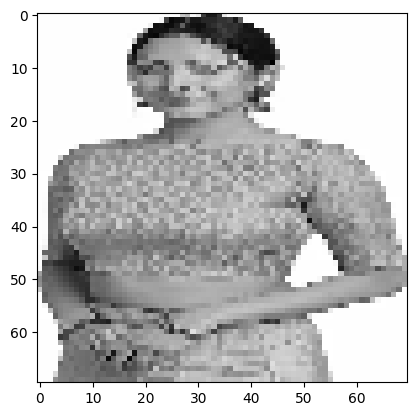

In [24]:
img = tensor_to_image(x_test[0])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[0]]}')
print(f'Predicted label: {labels[y_pred[0]]}')

True label: dhoti_pants
Predicted label: sherwanis


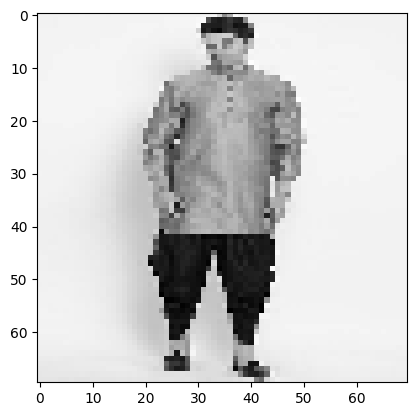

In [25]:
img = tensor_to_image(x_test[550])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[550]]}')
print(f'Predicted label: {labels[y_pred[550]]}')

## The image above shows a man wearing both dhoti pants and a sherwani

True label: kurta_men
Predicted label: sherwanis


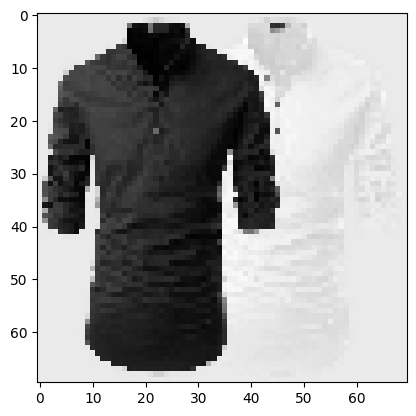

In [26]:
img = tensor_to_image(x_test[2000])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[2000]]}')
print(f'Predicted label: {labels[y_pred[2000]]}')

True label: lehenga
Predicted label: lehenga


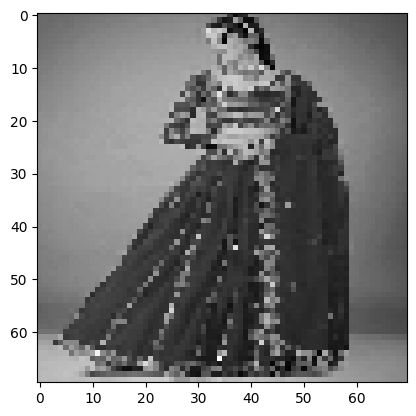

In [27]:
img = tensor_to_image(x_test[3000])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[3000]]}')
print(f'Predicted label: {labels[y_pred[3000]]}')

True label: mojaris_women
Predicted label: mojaris_women


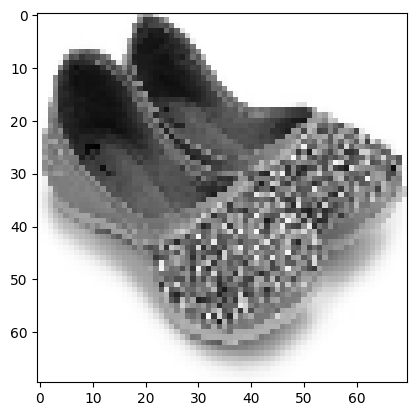

In [28]:
img = tensor_to_image(x_test[4000])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[4000]]}')
print(f'Predicted label: {labels[y_pred[4000]]}')

True label: saree
Predicted label: lehenga


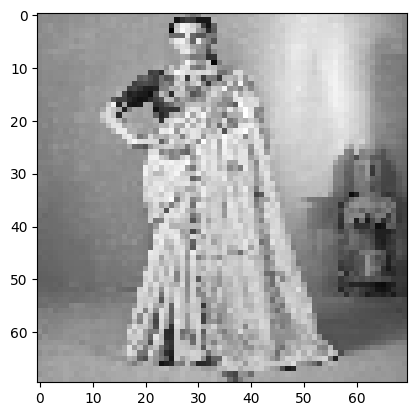

In [29]:
img = tensor_to_image(x_test[6400])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[6400]]}')
print(f'Predicted label: {labels[y_pred[6400]]}')

True label: sherwanis
Predicted label: sherwanis


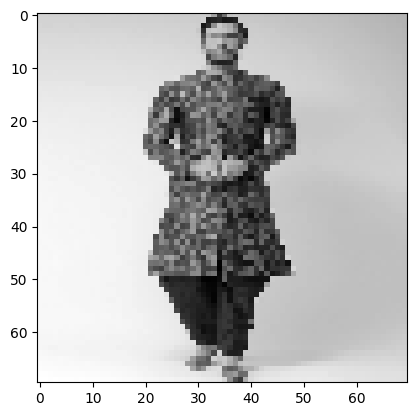

In [30]:
img = tensor_to_image(x_test[6600])
plt.imshow(img, cmap='gray')
print(f'True label: {labels[y_true[6600]]}')
print(f'Predicted label: {labels[y_pred[6600]]}')

In [31]:
# Making list of true labels from the true numerical labels using the dictionary labels
true_labels = []
for i in range(7297):
  label = y_true[i]
  true_label = labels[label]
  true_labels.append(true_label)

In [33]:
# Making list of predicted labels from the predicted numerical labels using the dictionary labels
pred_labels = []
for i in range(7297):
  pred_label = labels[y_pred[i]]
  pred_labels.append(pred_label)

In [34]:
cm = confusion_matrix(true_labels, pred_labels)
cm

array([[399,   0,  21,   2,   0,   1,  23,   2,   4,  12,   5,   3,  20,
          5,   3],
       [  0, 136,  21,   1,  34, 203,   7,   0,   0,   3,  31,   0,   4,
         54,   6],
       [  6,   1, 136,   6,   1,   2, 212,   0,   2,   2,  15,   1,  42,
         11,  63],
       [  1,   0,  14, 158,   0,   0, 227,   1,   0,   0,   7,   2,   8,
          3,  79],
       [  0,   0,   2,   1, 413,   1,   3,   0,   0,  19,   3,   1,   5,
         48,   4],
       [  0,  38,  19,   7,   0, 357,  20,   1,   1,   0,  12,   1,  28,
          2,  14],
       [  0,   0,   3,  32,   1,   0, 447,   0,   0,   0,   7,   0,   7,
          0,   3],
       [  1,  14,   5,   0,   0,   3,   9, 365,  77,   0,   8,   1,  13,
          3,   1],
       [  7,   8,  10,   0,   0,   2,   8,  59, 383,   0,   0,   0,  15,
          8,   0],
       [  1,   0,   1,   0,  31,   0,   2,   0,   0, 446,   0,   0,   0,
         19,   0],
       [  0,   0,   7,   3,   0, 161,  16,   0,   1,   0, 283,   8,   4,
       

<Axes: >

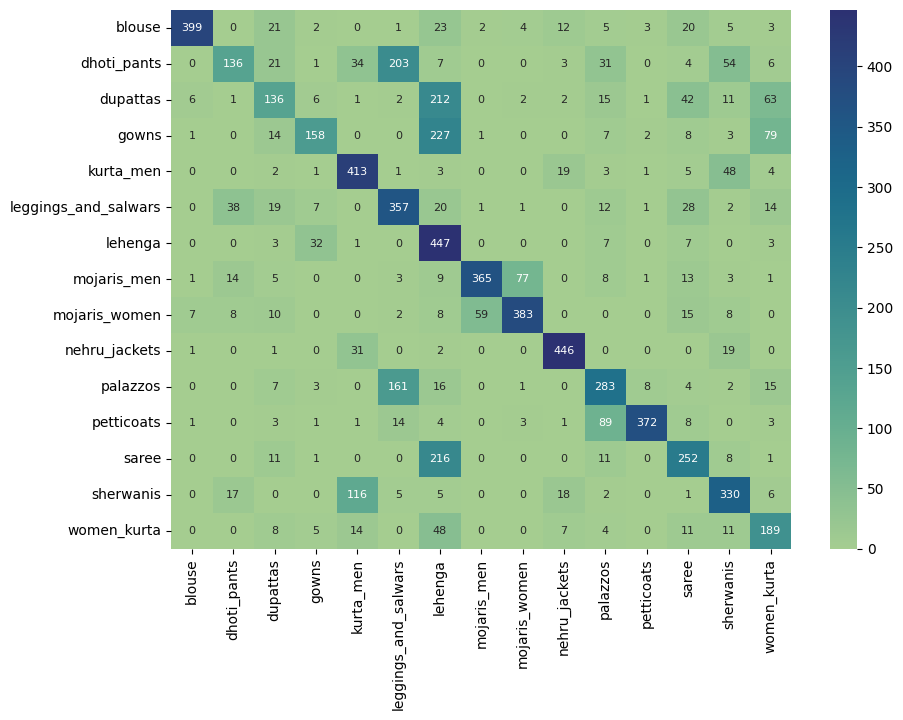

In [35]:
df_cm = pd.DataFrame(cm, index = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'saree', 'sherwanis', 'women_kurta'],
                  columns = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats',  'saree', 'sherwanis','women_kurta'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size":8}, fmt='d', cmap='crest')